In [13]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [14]:
SEGMENT_DURATION = 3 # in sec
FILES_PER_GENRE = 100
TRAIN_SIZE = 0.8

audio_files = {
        'blues': f"Audio_Features_{SEGMENT_DURATION}sec/blues/",
        'classical': f"Audio_Features_{SEGMENT_DURATION}sec/classical/",
        'country': f"Audio_Features_{SEGMENT_DURATION}sec/country/",
        'disco': f"Audio_Features_{SEGMENT_DURATION}sec/disco/",
        'hiphop': f"Audio_Features_{SEGMENT_DURATION}sec/hiphop/",
        'jazz': f"Audio_Features_{SEGMENT_DURATION}sec/jazz/",
        'metal': f"Audio_Features_{SEGMENT_DURATION}sec/metal/",
        'pop': f"Audio_Features_{SEGMENT_DURATION}sec/pop/",
        'reggae': f"Audio_Features_{SEGMENT_DURATION}sec/reggae/",
        'rock': f"Audio_Features_{SEGMENT_DURATION}sec/rock/"
}

train_files = []
train_files_genre = []
test_files = []
test_files_genre = []
for genre in audio_files:
    random_indexes = random.sample(range(FILES_PER_GENRE), FILES_PER_GENRE)
    train_indexes = random_indexes[:int(TRAIN_SIZE*FILES_PER_GENRE)]
    test_indexes = random_indexes[int(TRAIN_SIZE*FILES_PER_GENRE):]
    for n in train_indexes:
        train_files.append(f"{audio_files[genre]}{genre}{n}.csv")
        train_files_genre.append(genre)
    for n in test_indexes:
        test_files.append(f"{audio_files[genre]}{genre}{n}.csv")
        test_files_genre.append(genre)

In [15]:
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions=[]
        voters=[]
        for X in X_test.values:
            dst = self.X_train-X
            dst = dst * dst
            dst = dst.sum(axis='columns') ** 0.5
            dst = pd.DataFrame({'distance': dst,
                                'value': self.y_train})
            dst = dst.sort_values('distance')
            voters = dst.head(self.k).value
            predictions.append(voters.mode()[0])
        return predictions

In [16]:
X_train_data = []
for i, f in enumerate(train_files):
    csv_df = pd.read_csv(f, header = 0)
    csv_df["genre"] = train_files_genre[i]
    X_train_data.append(csv_df)

X_train = pd.concat(X_train_data, axis = 0, ignore_index = True)
y_train = X_train.pop("genre")
scaler = MinMaxScaler()
scaler.set_output(transform="pandas")
X_train = scaler.fit_transform(X_train)
clf = KNN(1)
clf.fit(X_train, y_train)

In [17]:
y_test = test_files_genre
y_pred = []
for f in test_files:
    X_test = pd.read_csv(f)
    X_test = scaler.transform(X_test)
    predictions = clf.predict(X_test)
    possible_genres, counts = np.unique(predictions, return_counts=True)
    genre = possible_genres[counts.argmax()]
    y_pred.append(genre)
    
print(f"Dokładność: {accuracy_score(y_test, y_pred)*100}%")

Dokładność: 82.5%


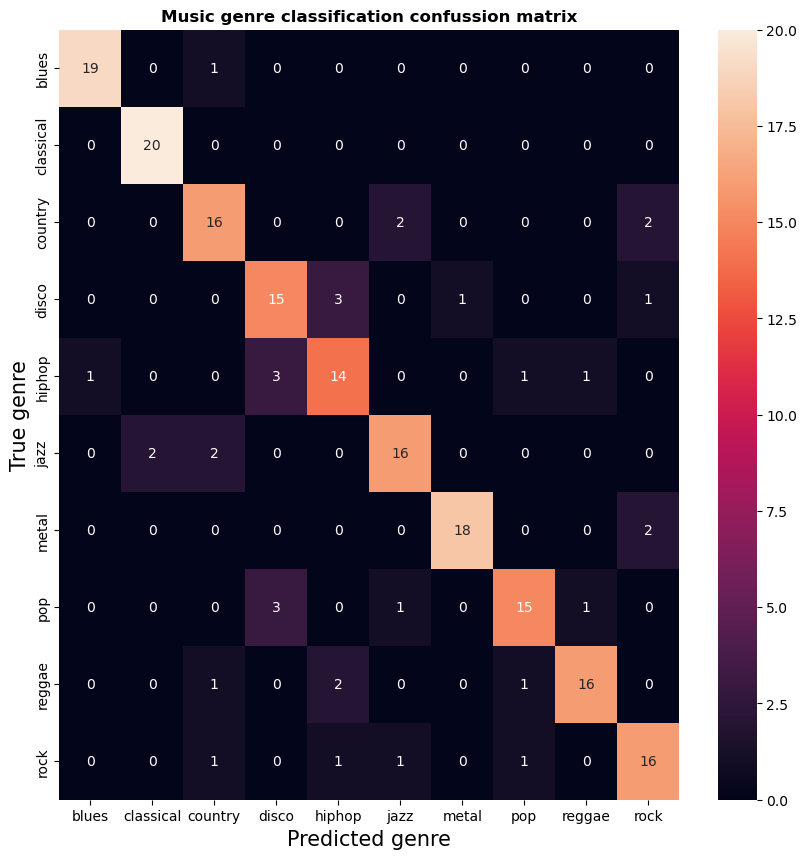

In [18]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize = (10, 10))
s = sns.heatmap(cm, annot=True, xticklabels = audio_files.keys(), yticklabels = audio_files.keys(), ax = ax)
s.set_xlabel("Predicted genre", fontsize = 15)
s.set_ylabel("True genre", fontsize = 15)
plt.title("Music genre classification confussion matrix", fontweight = "bold")
plt.show()